# Data Exploration and Visualization

This chapter includes a plot illustrating the distribution of machine states and a visualization of the machine states over a single day. These visualizations provide the reader with an intuitive understanding of how the states are derived from the data.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [4]:
df = pd.read_csv('/Users/bindiair/Desktop/datenanalyse_in_unternehmen/data_preparation/processed_datasets/data_with_timestamps_cleaned.csv')

## 2.1 Distribution of Machine States

The distribution plot reveals that "production" is the most frequently occurring state, followed by "idle." This was expected, as these two states constitute the majority of the foam processing workflow. States such as "remove top skin" or "block loading" are smaller intermediate steps performed in preparation for production.

In [5]:
# Define the numeric-to-English mapping
numeric_to_english = {
    0: 'Block Loading',
    1: 'Remove Side Skin',
    2: 'Gluing',
    3: 'Remove Top Skin',
    4: 'Production',
    5: 'Remove Bottom Skin',
    6: 'Idle'
}

df['_time'] = pd.to_datetime(df['_time'])
df['Label_numeric'] = df['Label']  # Preserve numeric labels
df['Label'] = df['Label'].map(numeric_to_english)  # Translate to English

# Calculate label distribution
label_distribution = df['Label'].value_counts()
label_distribution = label_distribution.to_dict()

# Extract names and values
names = list(label_distribution.keys())
values = list(label_distribution.values())

# Calculate the percentages
total = sum(label_distribution.values())
percentages = [f"{(v / total) * 100:.1f}%" for v in values]

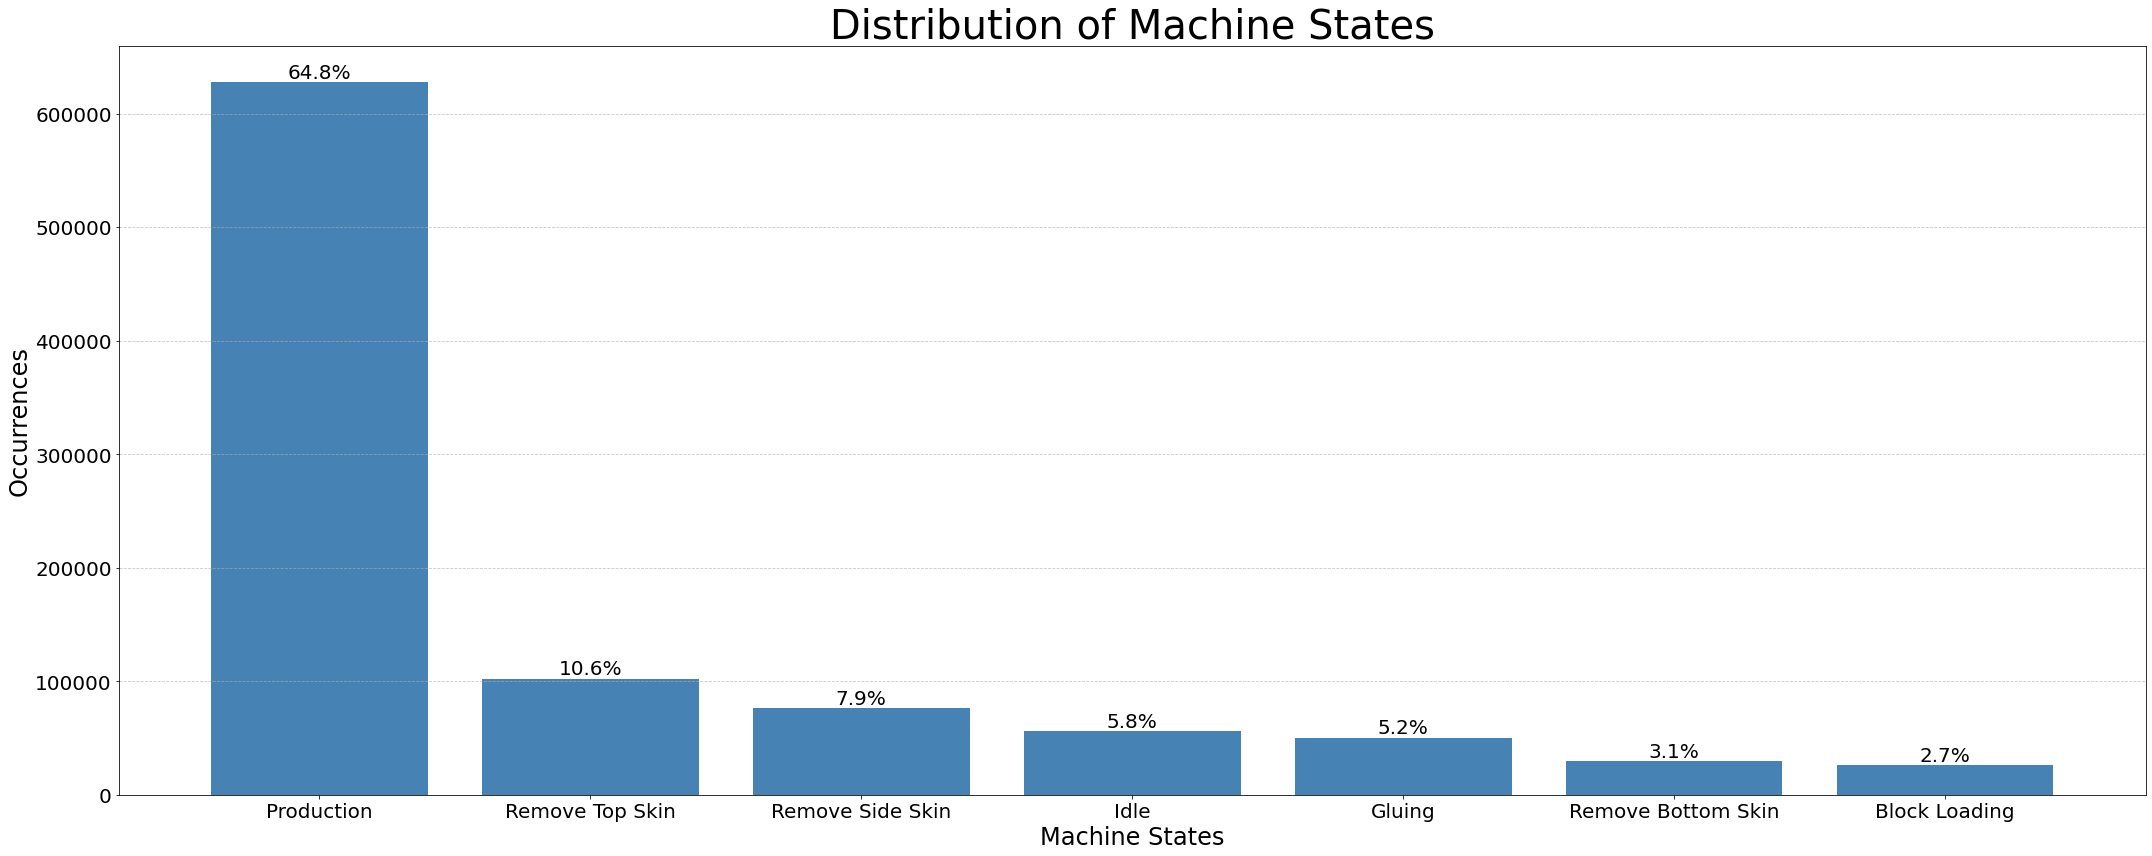

In [6]:
plt.figure(figsize=(30, 12))  
bars = plt.bar(names, values, color='steelblue')

plt.title("Distribution of Machine States", fontsize=40)  
for bar, percentage in zip(bars, percentages):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate in the center of the bar
        bar.get_height(),  # Y-coordinate on top of the bar
        percentage, 
        ha='center', va='bottom', fontsize=20 
    )

plt.xlabel("Machine States", fontsize=24)  
plt.ylabel("Occurrences", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 2.2 Machine State Visualization

To demonstrate how the states are derived from the data, the two most relevant columns are plotted over the span of one day, with the corresponding states marked on the plot. These columns are AggHoeheIst and HTBVIst.

AggHoeheIst represents the height of the foam and serves as a strong indicator of the machine's current state (e.g., a continuously decreasing aggregate height typically indicates production).

HTBVIst represents the speed of the main conveyor belt that transports the foam through the machine. Alternating negative and positive belt speeds, for instance, suggest that the skin is being removed.

The plot is intended to give the reader an understanding of how the labeling process was carried out and which information was used to assign the labels. Naturally, this description is a simplified representation of the overall process.

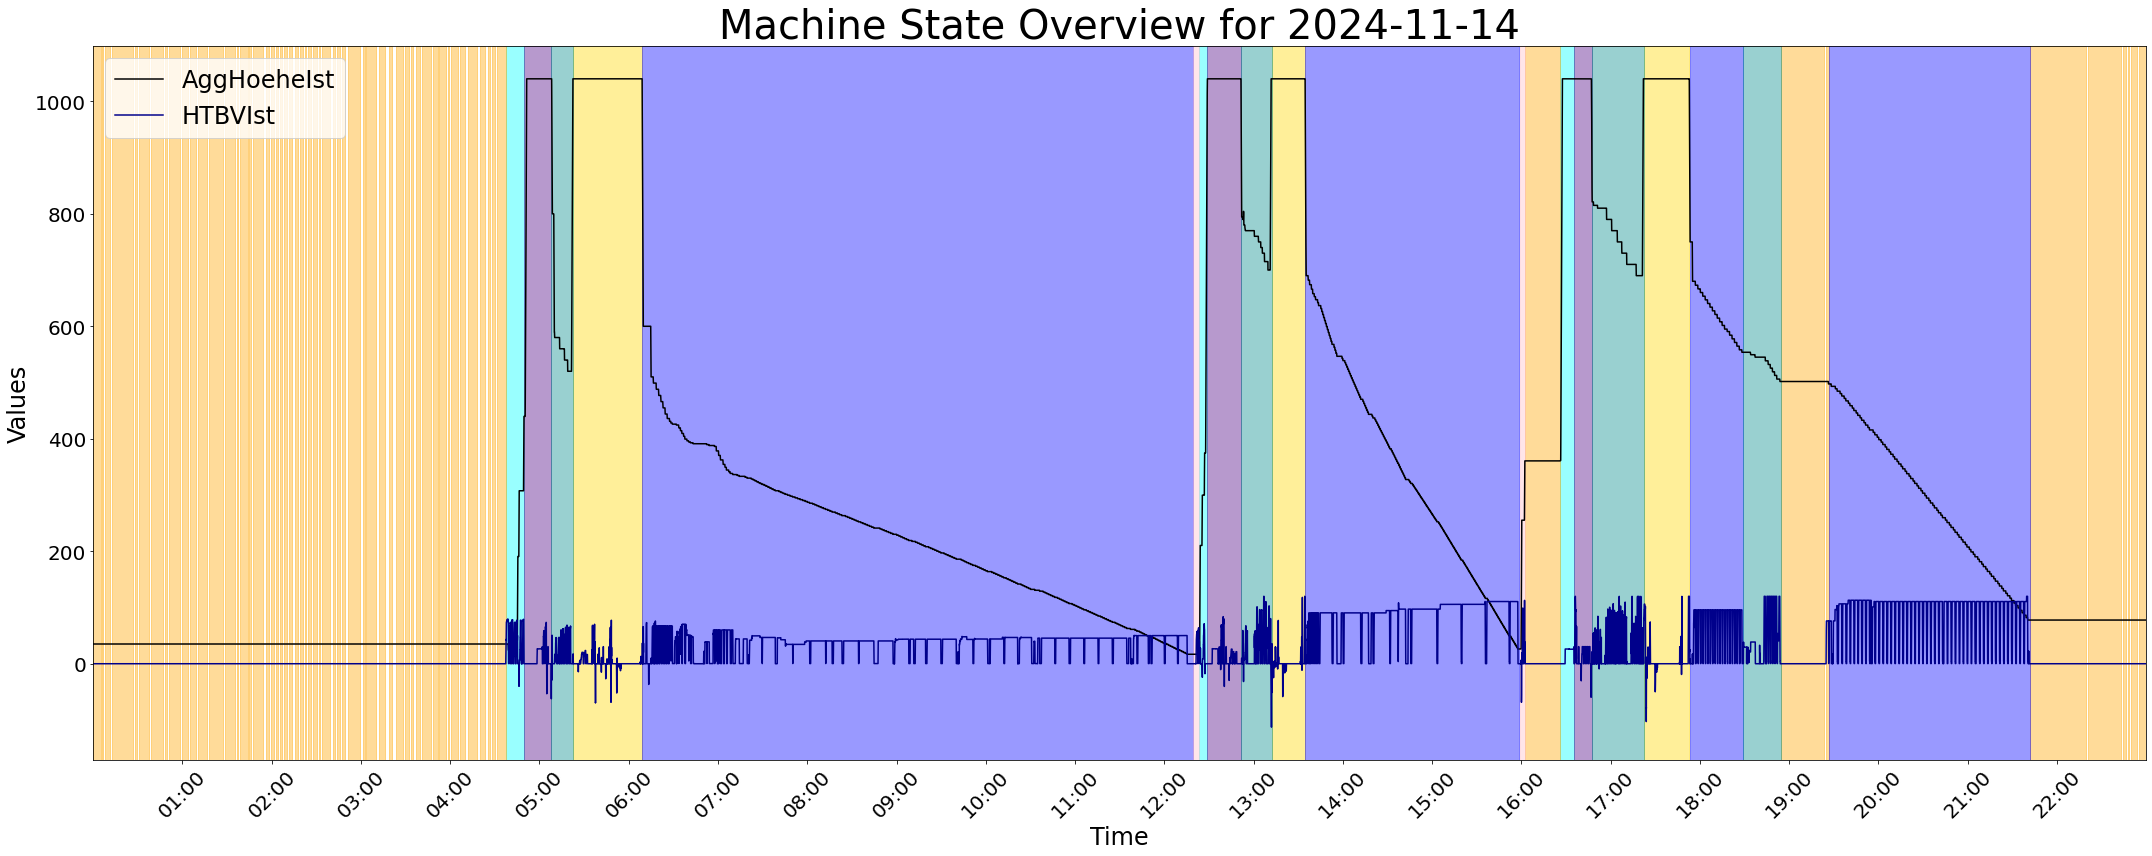

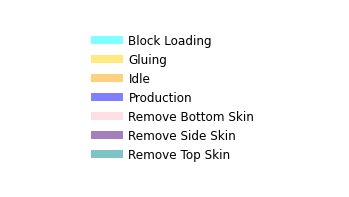

In [7]:
state_colors = ['cyan', 'gold', 'orange', 'blue', 'pink', 'indigo', 'darkcyan']

# Get the day with the most entries
most_entries_day = df['_time'].dt.date.value_counts().idxmax()
most_entries_day_df = df[df['_time'].dt.date == most_entries_day]
most_entries_day_df = most_entries_day_df.sort_values(by='_time')

# Extract unique labels
unique_labels = sorted(most_entries_day_df['Label'].unique())

# Map labels to colors
label_color_map = {label: state_colors[i] for i, label in enumerate(unique_labels)}

# Create the plot
fig, ax = plt.subplots(figsize=(30, 12))

x = pd.to_datetime(most_entries_day_df['_time'])
y1 = most_entries_day_df['AggHoeheIst']
y2 = most_entries_day_df['HTBVIst']

# Plot data
ax.plot(x, y1, label='AggHoeheIst', color='black')
ax.plot(x, y2, label='HTBVIst', color='darkblue')

# Add background color for states
for label in unique_labels:
    mask = most_entries_day_df['Label'] == label
    x_segment = x[mask]
    if x_segment.empty:
        print(f"No data for label: {label}")
        continue
    
    # Group consecutive time intervals belonging to the same state ('Label')
    segments = x_segment.groupby((x_segment.diff() > pd.Timedelta(minutes=1)).cumsum())
    for _, segment in segments:
        ax.axvspan(segment.iloc[0], segment.iloc[-1], color=label_color_map[label], alpha=0.4)

# Configure x-ticks and y-ticks
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45, fontsize=20)
plt.yticks(fontsize=20)

# Set axis limits
start_time = most_entries_day_df['_time'].min()
end_time = most_entries_day_df['_time'].max()
ax.set_xlim(start_time, end_time)

# Add labels and title
ax.set_xlabel('Time', fontsize=24)
ax.set_ylabel('Values', fontsize=24)
ax.set_title(f"Machine State Overview for {most_entries_day}", fontsize=40)  # Add date to title

# Add legend
ax.legend(loc='upper left', fontsize=24)

plt.tight_layout()
plt.show()

# Create legend for the states
fig, ax = plt.subplots(figsize=(6, 4))
state_legend_labels = [label for label in unique_labels]  # Directly use unique_labels as they are in English
state_patches = [plt.Line2D([0], [0], color=label_color_map[label], lw=8, alpha=0.5) for label in unique_labels]

fig.legend(state_patches, state_legend_labels, loc='center', fontsize=12, frameon=False)
plt.axis('off')
fig.subplots_adjust(top=0.2, bottom=0.1)

plt.show()

## Correlation Analysis

In this section, the correlations between features are visualized using a correlation matrix. For a more concise overview, only correlations greater than 0.1 are displayed.

Additionally, a plot is provided to show the correlation of each feature with the target variable. As previously described, the aggregate height (AggHoeheIst) is a key feature for explaining the target variable. Another important feature is the operating mode of the machine, which indicates whether the machine is running in automatic (BetriebsartBSVE)  or manual (BetriebsartManuell) mode. Production typically occurs in automatic mode, whereas tasks like skin removal are usually performed when the machine is manually operated.

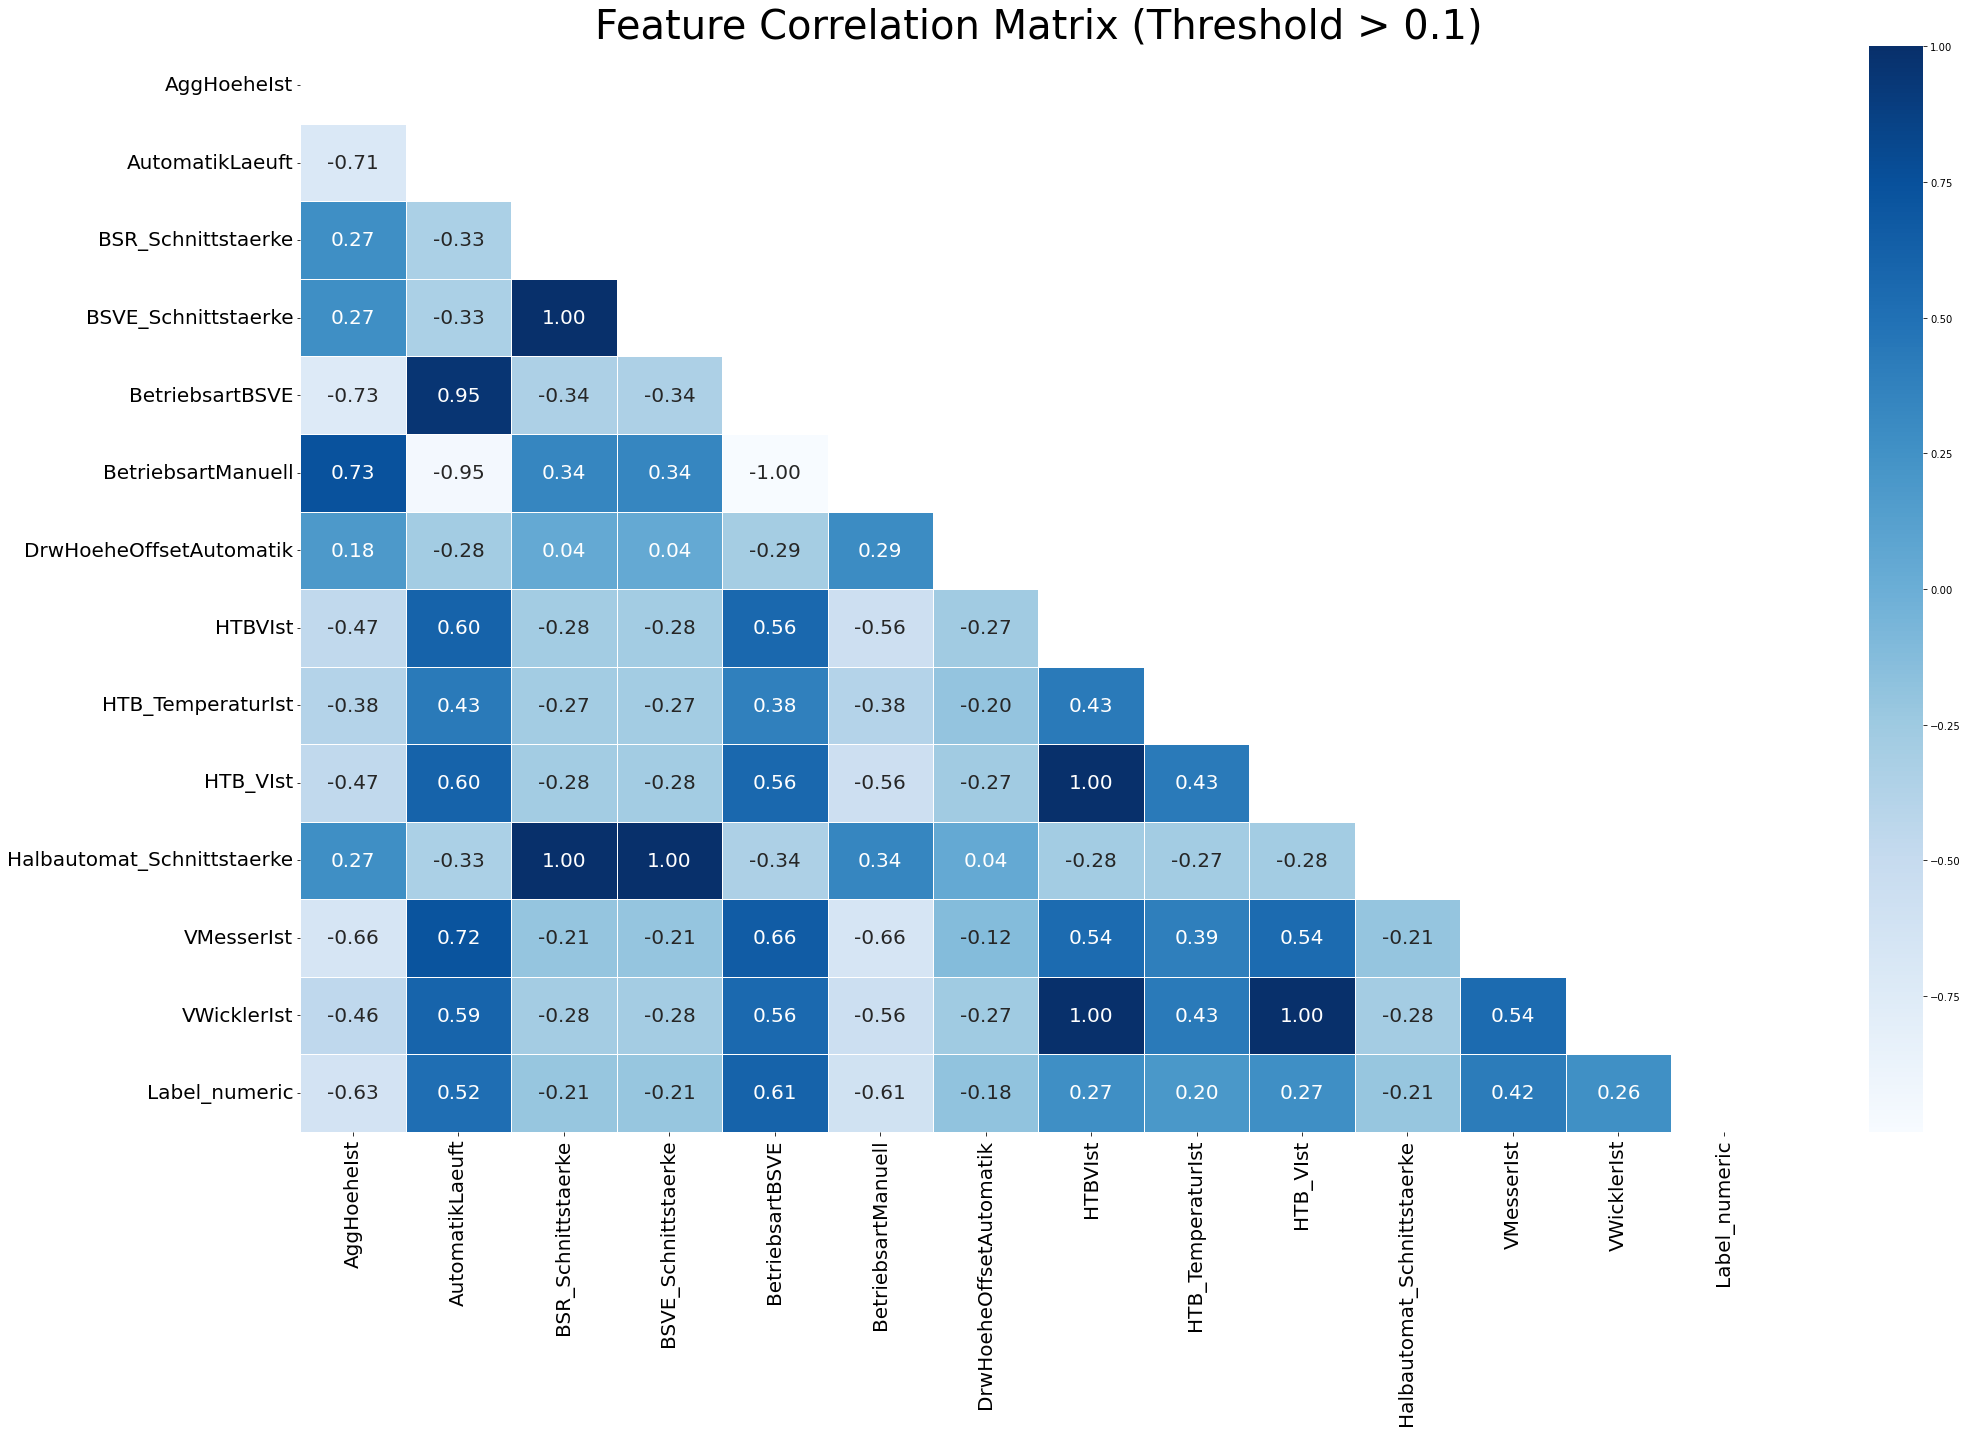

In [8]:
numerical_features = df.select_dtypes(include='number')

correlation_matrix = numerical_features.corr()

correlation_threshold = 0.1
strong_corr_features = correlation_matrix['Label_numeric'][correlation_matrix['Label_numeric'].abs() > correlation_threshold].index
filtered_corr_matrix = correlation_matrix.loc[strong_corr_features, strong_corr_features]

# Hide redundant values in the symmetric matrix
mask = np.triu(np.ones_like(filtered_corr_matrix, dtype=bool))

# Heatmap for filtered correlation matrix
plt.figure(figsize=(30, 20))
sns.heatmap(
    filtered_corr_matrix, 
    mask=mask, 
    annot=True,  # Show percentages
    fmt=".2f",  # Format percentages
    cmap='Blues', 
    cbar=True, 
    linewidths=0.5,  
    annot_kws={"size": 20}  # Size of percentages
)

plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=20)
plt.title('Feature Correlation Matrix (Threshold > 0.1)', fontsize=40)
plt.tight_layout()
plt.show()

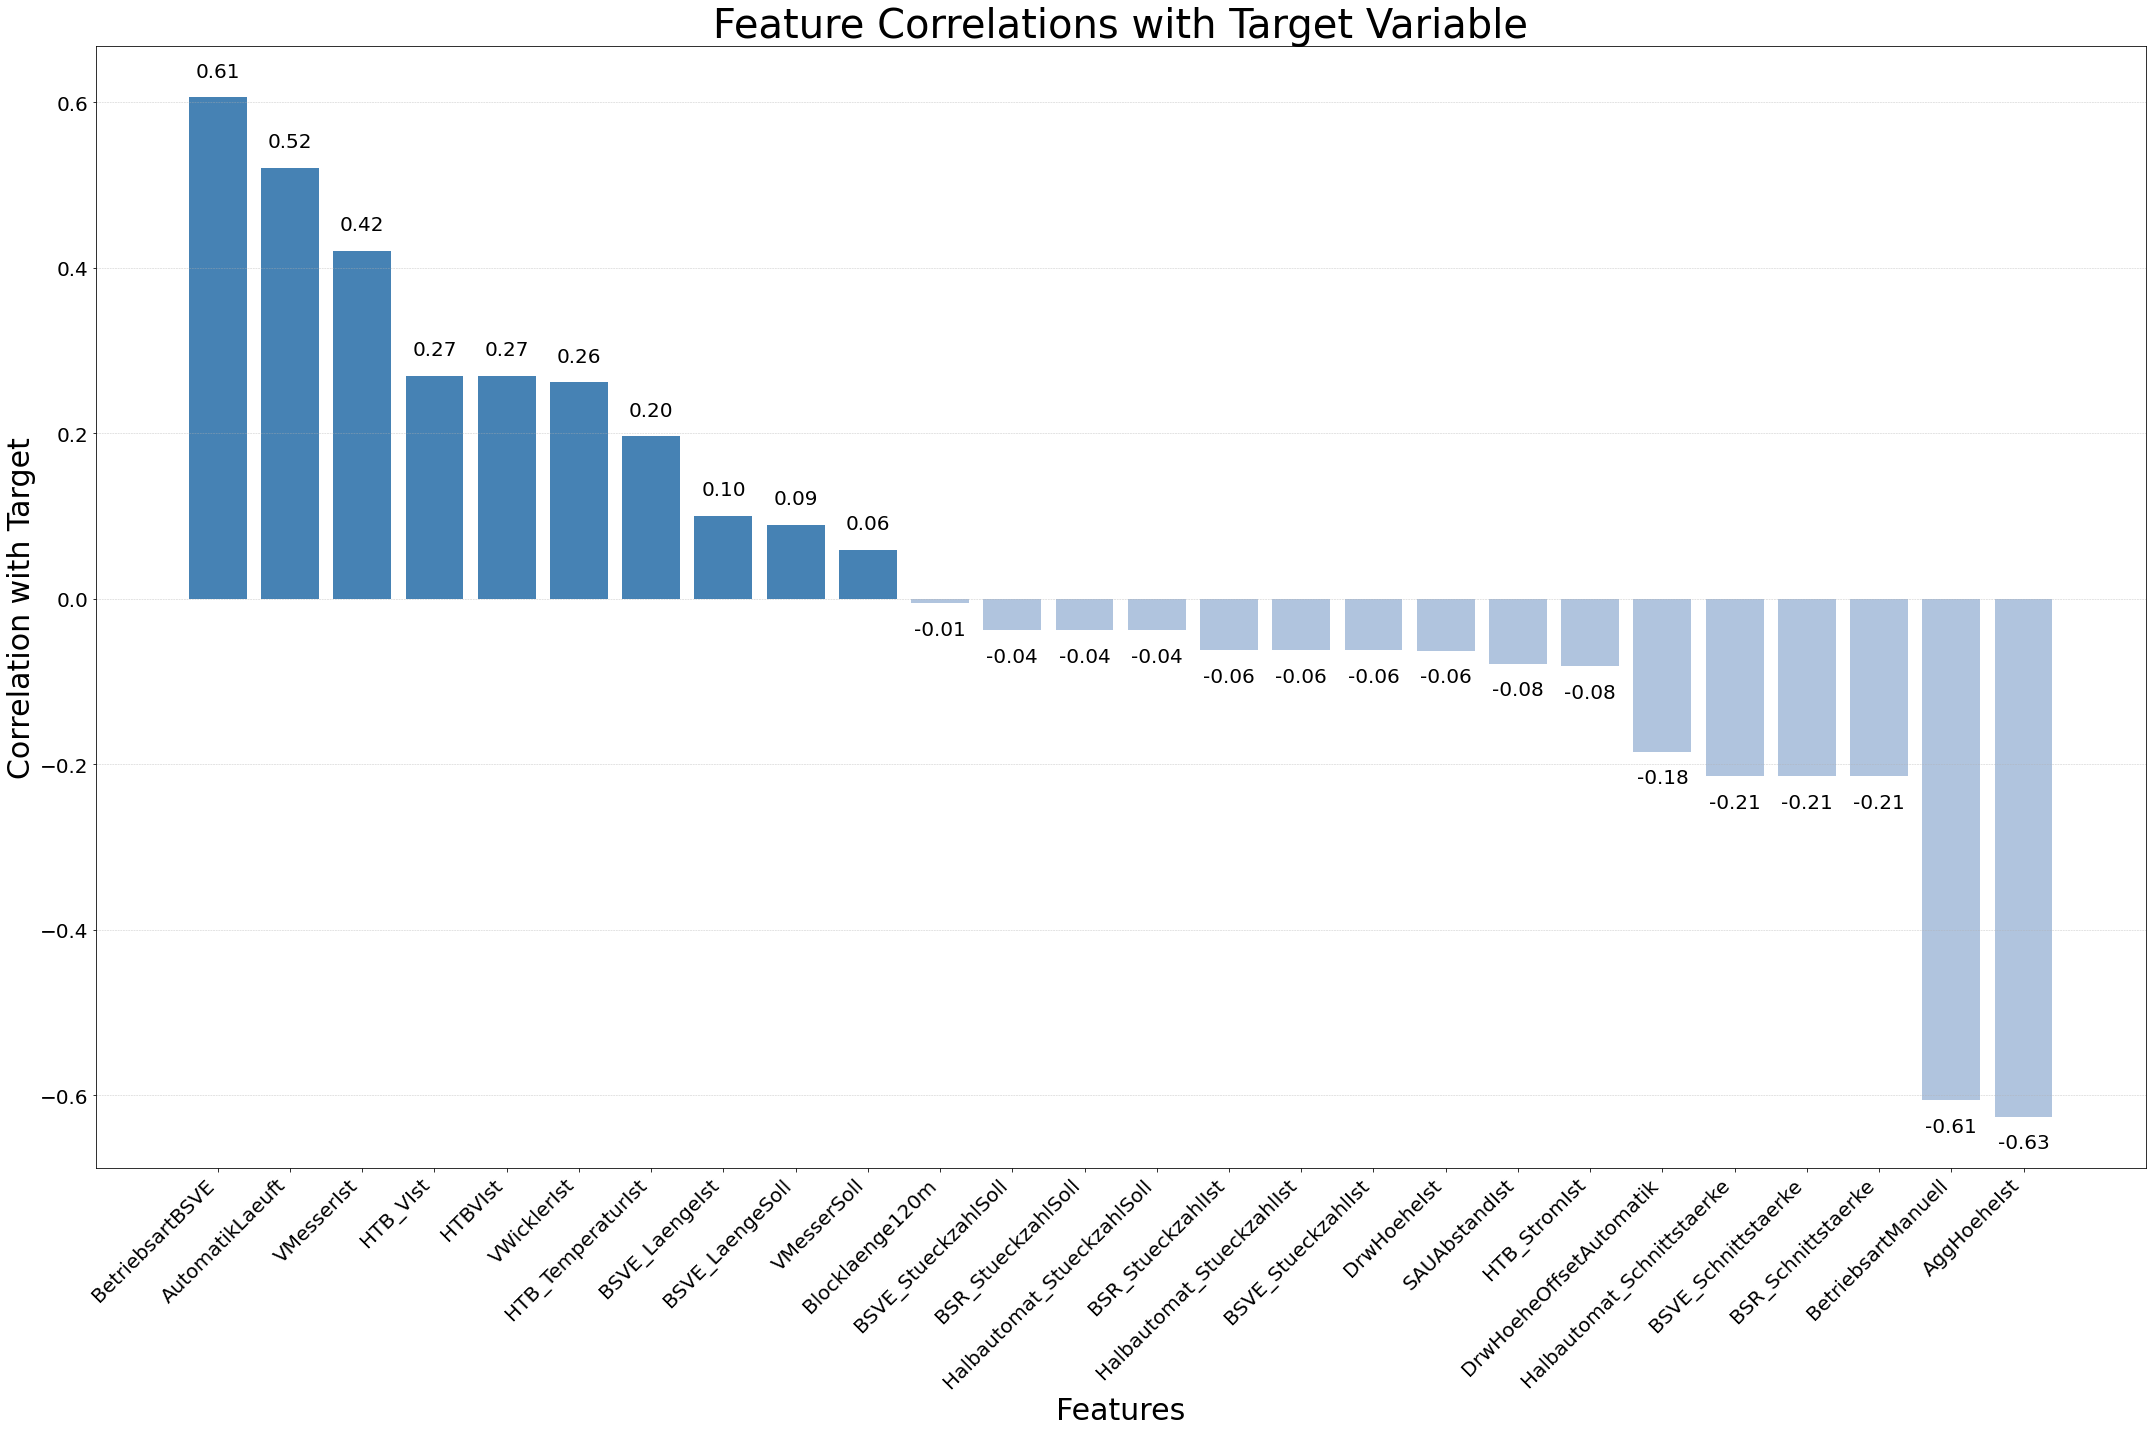

In [9]:
# Calculate correlations with the target variable
target_corr = correlation_matrix['Label_numeric']

relevant_corr = target_corr.drop('Label_numeric')  
relevant_corr = relevant_corr[relevant_corr.notna() & (relevant_corr != 0)]
relevant_corr = relevant_corr.sort_values(ascending=False)

# Bar plot for correlations with the target variable
plt.figure(figsize=(30, 20)) 
colors = ['steelblue' if corr > 0 else 'lightsteelblue' for corr in relevant_corr]
bars = plt.bar(relevant_corr.index, relevant_corr, color=colors)

# Add correlation values above bars
for bar, corr in zip(bars, relevant_corr):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.02 * np.sign(bar.get_height()),
        f"{corr:.2f}",
        ha='center',
        va='bottom' if corr > 0 else 'top',
        fontsize=20  
    )

plt.title('Feature Correlations with Target Variable', fontsize=40) 
plt.xlabel('Features', fontsize=30) 
plt.ylabel('Correlation with Target', fontsize=30)
plt.xticks(rotation=45, ha='right', fontsize=20)  
plt.yticks(fontsize=20)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()